In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import  mean_pinball_loss

import requests
from datetime import datetime, date, timedelta
from tqdm import tqdm

import ephem

In [186]:
# Set start-, forecast-, and end-date here
week = "1"
start_dt = '2018-12-24 00:00:00'        # Data Availability starts here
forecast_dt = '2023-11-15 23:00:00'     # Wednesday/Thursday midnight
forecast_date = '2023-11-15' 
end_dt = '2023-11-18 23:00:00'          # Saturday/Sunday midnight

In [187]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[4*52:]

 
    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [188]:
# Quantiles
alpha = np.array([.025, .25, .5, .75, .975])

# Create dataframe
df_raw = get_energy_data()
df_raw = df_raw.rename(columns={"Netzlast_Gesamt": "gesamt"})
df_raw['gesamt'] = df_raw['gesamt'] / 1000

  0%|          | 0/275 [00:00<?, ?it/s]C:\Users\Bilal\AppData\Local\Temp\ipykernel_13728\2279548712.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 275/275 [00:39<00:00,  6.91it/s]


In [189]:
# filter data
df = df_raw.copy()
df = df.loc[(df.index >= start_dt) & (df.index <= end_dt)]
df

,gesamt
date_time,
2018-12-24 00:00:00,42.02925
2018-12-24 01:00:00,39.61025
2018-12-24 02:00:00,39.13875
2018-12-24 03:00:00,39.42100
2018-12-24 04:00:00,40.74775
...,...
2023-11-18 19:00:00,56.35650
2023-11-18 20:00:00,53.47700
2023-11-18 21:00:00,51.29375


In [190]:
holidays = pd.read_csv('C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\holidays.csv')
# holidays = np.array(holidays)
holidays.index = pd.to_datetime(holidays['x'])
holidays['date'] = holidays.index.date
holidays

,x,date
x,,
2018-01-01,2018-01-01,2018-01-01
2018-01-06,2018-01-06,2018-01-06
2018-03-30,2018-03-30,2018-03-30
2018-04-02,2018-04-02,2018-04-02
2018-05-01,2018-05-01,2018-05-01
...,...,...
2024-10-31,2024-10-31,2024-10-31
2024-11-01,2024-11-01,2024-11-01
2024-12-24,2024-12-24,2024-12-24


Generate Features, Lag Features, and Daylight Hours

In [191]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['date'] = df.index.date # to join with daylight hours
    return df

In [192]:
def add_lags(df):                       # more lags? yesterday, last week, ...
    target_map = df['gesamt'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364, so we get this day last year on the same weekday 
    # df['lag3'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    # df['lag4'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [193]:
# Define the observer location (latitude and longitude for Germany)
latitude = '51.1657'  # Latitude for Germany
longitude = '10.4515'  # Longitude for Germany

# Create an observer object
germany = ephem.Observer()
germany.lat = latitude
germany.lon = longitude

# Set the date for which you want to calculate sunrise time
start_date = df.index.min().date()      # begins at same day as df
end_date =  df.index.max().date()           # + timedelta(days=7)

# Dictionary to store daylight hours for each date
daylight_hours_dict = {}


current_date = start_date
while current_date <= end_date:
    # Set the observer's date
    germany.date = current_date

    # Compute the sunrise time
    sunrise = germany.next_rising(ephem.Sun())
    sunset = germany.next_setting(ephem.Sun())

    daylight_hours = (sunset - sunrise) * 24  # Convert from days to hours

    # Store daylight hours for current date in the dictionary
    daylight_hours_dict[current_date] = daylight_hours
    # Move to next dax
    current_date += timedelta(days=1)

# Print daylight hours for each date
for date, daylight_hours in daylight_hours_dict.items():
    print(f"{date}: Daylight: {daylight_hours:.2f} hours")

2018-12-24: Daylight: 7.91 hours
2018-12-25: Daylight: 7.91 hours
2018-12-26: Daylight: 7.92 hours
2018-12-27: Daylight: 7.93 hours
2018-12-28: Daylight: 7.94 hours
2018-12-29: Daylight: 7.95 hours
2018-12-30: Daylight: 7.97 hours
2018-12-31: Daylight: 7.98 hours
2019-01-01: Daylight: 8.00 hours
2019-01-02: Daylight: 8.02 hours
2019-01-03: Daylight: 8.04 hours
2019-01-04: Daylight: 8.06 hours
2019-01-05: Daylight: 8.09 hours
2019-01-06: Daylight: 8.11 hours
2019-01-07: Daylight: 8.14 hours
2019-01-08: Daylight: 8.17 hours
2019-01-09: Daylight: 8.20 hours
2019-01-10: Daylight: 8.23 hours
2019-01-11: Daylight: 8.26 hours
2019-01-12: Daylight: 8.30 hours
2019-01-13: Daylight: 8.33 hours
2019-01-14: Daylight: 8.37 hours
2019-01-15: Daylight: 8.41 hours
2019-01-16: Daylight: 8.45 hours
2019-01-17: Daylight: 8.49 hours
2019-01-18: Daylight: 8.53 hours
2019-01-19: Daylight: 8.57 hours
2019-01-20: Daylight: 8.62 hours
2019-01-21: Daylight: 8.66 hours
2019-01-22: Daylight: 8.71 hours
2019-01-23

In [194]:
# # Short test
# germany.date = df.index.min().date()
# print(germany.next_rising(ephem.Sun()))
# print(df.index.min().date())

In [195]:
# Convert daylight_hours_dict to a DataFrame for easier manipulation
daylight_df = pd.DataFrame.from_dict(daylight_hours_dict, orient='index', columns=['daylight']) 
daylight_df
# Following steps only relevant for working version (unknown future)
# daylight_df_train = daylight_df.iloc[daylight_df.index < df.index.max().date()]
# Merge df and daylight_df for the observed data
# df = pd.merge(df, daylight_df_train, left_on='date', right_index=True)
# df

,daylight
2018-12-24,7.906935
2018-12-25,7.912347
2018-12-26,7.919527
2018-12-27,7.928466
2018-12-28,7.939154
...,...
2023-11-14,9.000053
2023-11-15,8.949039
2023-11-16,8.898812
2023-11-17,8.849408


In [196]:
df = create_features(df)
df = add_lags(df)
df = pd.merge(df, daylight_df, left_on='date', right_index=True)

df['isHoliday'] = 0
# Mark holidays as 1
df.loc[df['date'].isin(holidays['date']), 'isHoliday'] = 1

df_train = df.loc[df.index <= forecast_dt]

df_test = df.loc[df.index > forecast_dt]


In [197]:
# FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
#             'lag1','lag2', 'lag3', 'lag4', 'daylight', 'isHoliday']           

FEATURES = ['lag1','lag2', 'lag3']           

                                  
TARGET = 'gesamt'

X_all = df_train[FEATURES]
y_all = df_train[TARGET]

X_all

,lag1,lag2,lag3
date_time,,,
2018-12-24 00:00:00,NaN,NaN,NaN
2018-12-24 01:00:00,NaN,NaN,NaN
2018-12-24 02:00:00,NaN,NaN,NaN
2018-12-24 03:00:00,NaN,NaN,NaN
2018-12-24 04:00:00,NaN,NaN,NaN
...,...,...,...
2023-11-15 19:00:00,67.04575,57.23850,64.42300
2023-11-15 20:00:00,63.59600,54.92700,61.16100
2023-11-15 21:00:00,59.37450,52.48475,57.43450


In [198]:
# Train on all data

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective = 'reg:quantileerror',        
                       quantile_alpha = alpha,                 
                       max_depth=5,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-quantile:27.84023


[100]	validation_0-quantile:8.28584
[200]	validation_0-quantile:2.81305
[300]	validation_0-quantile:1.26357
[400]	validation_0-quantile:0.83254
[499]	validation_0-quantile:0.71516


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:quantileerror', ...)

In [125]:
# Save model
reg.save_model('model.json')

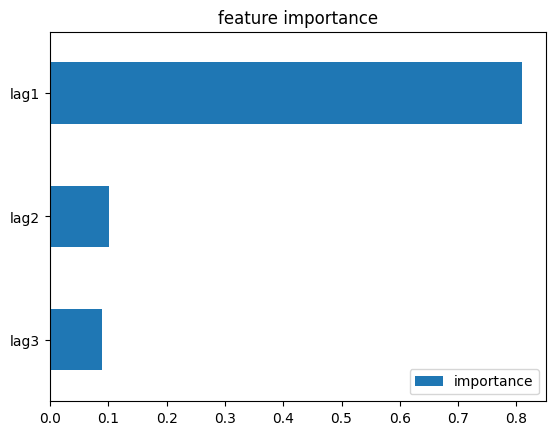

In [199]:
# Feature Importances
reg.feature_importances_
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])
fi.sort_values('importance').plot(kind = 'barh', title = 'feature importance')
plt.show()


In [127]:
# Model parameters
model_params = reg.get_params()
print(model_params)

{'objective': 'reg:quantileerror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'quantile_alpha': array([0.025, 0.25 , 0.5  , 0.75 , 0.975])}


In [128]:
# Tree Structure

Forecast

In [129]:
## Following code only relevant if future unknown 
# Create future dataframe
# future = pd.date_range('2024-03-19', '2025-03-15', freq='1h')
# future_df = pd.DataFrame(index=future)
# future_df['isFuture'] = True
# df['isFuture'] = False
# df_and_future = pd.concat([df, future_df])
# df_and_future = create_features(df_and_future)
# df_and_future = add_lags(df_and_future)
# df_and_future

# df_and_future.drop('daylight', axis=1, inplace=True) # delete daylight column 
# df_and_future = pd.merge(df_and_future, daylight_df, left_on='date', right_index=True) # add daylight column including future values to df
# df_and_future#
df_test


,gesamt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date,lag1,lag2,lag3,daylight
date_time,,,,,,,,,,,,,,
2023-11-16 00:00:00,49.73275,0,3,4,11,2023,320,16,46,2023-11-16,41.68325,49.57475,47.30625,8.898812
2023-11-16 01:00:00,48.60125,1,3,4,11,2023,320,16,46,2023-11-16,39.94700,47.83400,46.07150,8.898812
2023-11-16 02:00:00,47.75575,2,3,4,11,2023,320,16,46,2023-11-16,39.18325,47.20950,45.40700,8.898812
2023-11-16 03:00:00,48.82950,3,3,4,11,2023,320,16,46,2023-11-16,38.99750,47.46825,46.09300,8.898812
2023-11-16 04:00:00,49.91475,4,3,4,11,2023,320,16,46,2023-11-16,39.53750,48.60450,47.39300,8.898812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-19 19:00:00,53.72425,19,6,4,11,2023,323,19,46,2023-11-19,65.46025,53.63775,52.57250,8.753203
2023-11-19 20:00:00,51.25950,20,6,4,11,2023,323,19,46,2023-11-19,62.23250,50.98700,50.36225,8.753203
2023-11-19 21:00:00,49.13150,21,6,4,11,2023,323,19,46,2023-11-19,59.06100,49.50400,48.44475,8.753203


In [130]:
future_w_features = df_test.copy()

future_w_features['q0.025'] = reg.predict(future_w_features[FEATURES])[:,0]
future_w_features['q0.25'] = reg.predict(future_w_features[FEATURES])[:,1]
future_w_features['q0.5'] = reg.predict(future_w_features[FEATURES])[:,2]
future_w_features['q0.75'] = reg.predict(future_w_features[FEATURES])[:,3]
future_w_features['q0.975'] = reg.predict(future_w_features[FEATURES])[:,4]

future_w_features

,gesamt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date,lag1,lag2,lag3,daylight,q0.025,q0.25,q0.5,q0.75,q0.975
date_time,,,,,,,,,,,,,,,,,,,
2023-11-16 00:00:00,49.73275,0,3,4,11,2023,320,16,46,2023-11-16,41.68325,49.57475,47.30625,8.898812,43.580387,46.973652,48.440479,50.201405,52.569344
2023-11-16 01:00:00,48.60125,1,3,4,11,2023,320,16,46,2023-11-16,39.94700,47.83400,46.07150,8.898812,43.027672,45.875839,47.061340,48.325932,51.181099
2023-11-16 02:00:00,47.75575,2,3,4,11,2023,320,16,46,2023-11-16,39.18325,47.20950,45.40700,8.898812,42.723305,45.445457,46.756371,48.077549,50.240280
2023-11-16 03:00:00,48.82950,3,3,4,11,2023,320,16,46,2023-11-16,38.99750,47.46825,46.09300,8.898812,43.027672,45.390671,46.904259,48.109837,50.283062
2023-11-16 04:00:00,49.91475,4,3,4,11,2023,320,16,46,2023-11-16,39.53750,48.60450,47.39300,8.898812,43.240265,46.246548,47.567841,49.143925,51.534073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-19 19:00:00,53.72425,19,6,4,11,2023,323,19,46,2023-11-19,65.46025,53.63775,52.57250,8.753203,48.390175,51.797932,53.199814,54.706787,56.594063
2023-11-19 20:00:00,51.25950,20,6,4,11,2023,323,19,46,2023-11-19,62.23250,50.98700,50.36225,8.753203,46.159012,50.031166,51.077435,52.273422,53.690102
2023-11-19 21:00:00,49.13150,21,6,4,11,2023,323,19,46,2023-11-19,59.06100,49.50400,48.44475,8.753203,46.159012,49.163776,50.220100,50.824715,52.630768


FORECAST EVALUATION

Graphical

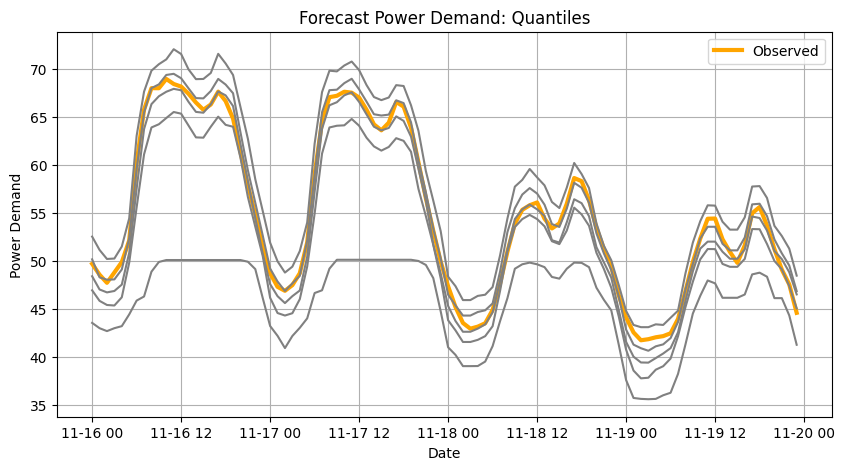

In [131]:
plt.figure(figsize=(10,5))

plt.plot(future_w_features.index, future_w_features['gesamt'], label= 'Observed', lw=3, color='orange')

for column in [ 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']:
    plt.plot(future_w_features.index, future_w_features[column], color='gray') # label = column
    
plt.xlabel('Date')
plt.ylabel('Power Demand')
plt.title('Forecast Power Demand: Quantiles')
plt.legend()
plt.grid(True)
plt.show()

Quantile Score

In [132]:
def quantile_loss(alpha, true, pred):
    return 2 * alpha * (true - pred) if true > pred else 2* (1 - alpha) * (pred - true)

In [133]:
mean_pinball_loss(y_true=future_w_features['gesamt'], y_pred=future_w_features['q0.025'], alpha = alpha[0])

0.2227693993886312

In [134]:
FOREVAL = ['gesamt', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']

df_foreval = future_w_features[FOREVAL].copy()

In [135]:
quantile_loss(alpha = alpha[0], true = df_foreval.iloc[0,0], pred = df_foreval.iloc[0, 1])

0.30761814422607436

In [136]:
quantile_loss(alpha = alpha[4], true = df_foreval.iloc[len(df_foreval)-1,0], pred = df_foreval.iloc[len(df_foreval)-1, 4+1])

0.19369497222900395

In [137]:
losses = []
# Iterate over alphas
for a in range(len(alpha)):
    # Initialize a list to store losses for current alpha
    alpha_losses = []
    
    # Iterate over rows
    for i in range(len(df_foreval)):
        loss = quantile_loss(alpha = alpha[a], true = df_foreval.iloc[i,0], pred = df_foreval.iloc[i, a+1])
        alpha_losses.append(loss)
        
    # Append the losses for current alpha to the main losses list
    losses.append(alpha_losses)
    
# Convert losses to a DataFrame
losses_df = pd.DataFrame(losses).T

QUANTILESCORES = ['qs0.025', 'qs0.25', 'qs0.5', 'qs0.75', 'qs0.975']
losses_df.columns = QUANTILESCORES
losses_df.index = df_foreval.index
losses_df

,qs0.025,qs0.25,qs0.5,qs0.75,qs0.975
date_time,,,,,
2023-11-16 00:00:00,0.307618,1.379549,1.292271,0.234327,0.141830
2023-11-16 01:00:00,0.278679,1.362705,1.539910,0.412978,0.128992
2023-11-16 02:00:00,0.251622,1.155146,0.999379,0.160899,0.124227
2023-11-16 03:00:00,0.290091,1.719415,1.925241,1.079495,0.072678
2023-11-16 04:00:00,0.333724,1.834101,2.346909,1.156238,0.080966
...,...,...,...,...,...
2023-11-19 19:00:00,0.266704,0.963159,0.524436,0.491269,0.143491
2023-11-19 20:00:00,0.255024,0.614167,0.182065,0.506961,0.121530
2023-11-19 21:00:00,0.148624,0.048415,1.088600,0.846607,0.174963


In [138]:

# average quantile loss
losses_df['mean_qs'] = losses_df.mean(axis=1)
losses_df['sum_qs'] = losses_df.sum(axis=1)
losses_df


,qs0.025,qs0.25,qs0.5,qs0.75,qs0.975,mean_qs,sum_qs
date_time,,,,,,,
2023-11-16 00:00:00,0.307618,1.379549,1.292271,0.234327,0.141830,0.671119,4.026714
2023-11-16 01:00:00,0.278679,1.362705,1.539910,0.412978,0.128992,0.744653,4.467917
2023-11-16 02:00:00,0.251622,1.155146,0.999379,0.160899,0.124227,0.538255,3.229529
2023-11-16 03:00:00,0.290091,1.719415,1.925241,1.079495,0.072678,1.017384,6.104305
2023-11-16 04:00:00,0.333724,1.834101,2.346909,1.156238,0.080966,1.150388,6.902327
...,...,...,...,...,...,...,...
2023-11-19 19:00:00,0.266704,0.963159,0.524436,0.491269,0.143491,0.477812,2.866870
2023-11-19 20:00:00,0.255024,0.614167,0.182065,0.506961,0.121530,0.335950,2.015698
2023-11-19 21:00:00,0.148624,0.048415,1.088600,0.846607,0.174963,0.461442,2.768652


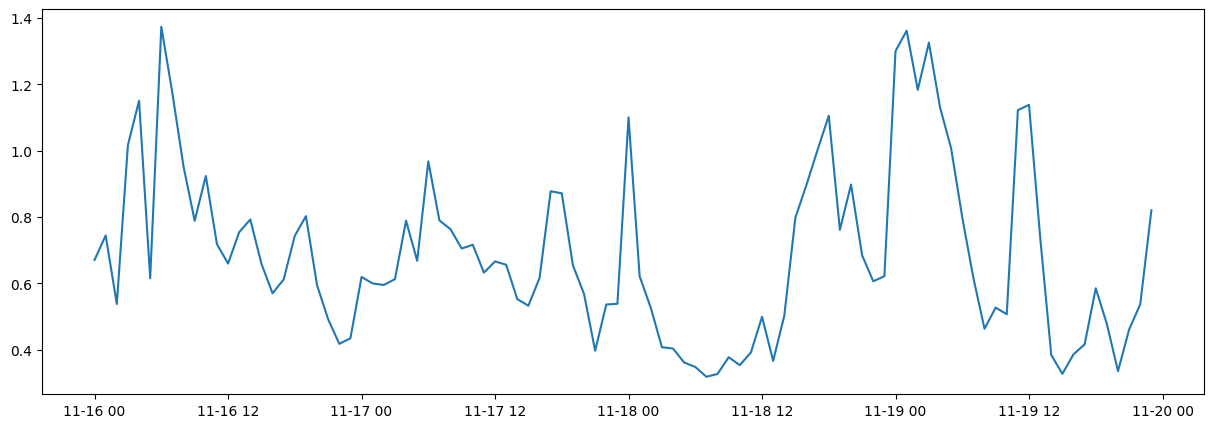

In [139]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(losses_df.index, losses_df['mean_qs'])
plt.show()


Relevant Hours

In [140]:
# 36, 40, 44, 60, 64, 68
# Friday and Saturday: 12, 16, 20 
df_sub = future_w_features.loc[future_w_features.dayofweek.isin([4, 5])].copy()
df_sub = df_sub.loc[df_sub.hour.isin([12,16,20])]
df_sub

,gesamt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date,lag1,lag2,lag3,daylight,q0.025,q0.25,q0.5,q0.75,q0.975
date_time,,,,,,,,,,,,,,,,,,,
2023-11-17 12:00:00,67.05325,12,4,4,11,2023,321,17,46,2023-11-17,68.20725,67.11725,66.61700,8.849408,50.155540,64.118431,66.601700,67.905060,69.916245
2023-11-17 16:00:00,64.44025,16,4,4,11,2023,321,17,46,2023-11-17,66.80275,63.48250,63.31825,8.849408,50.155540,61.908325,63.887154,65.276756,67.059822
2023-11-17 20:00:00,60.30600,20,4,4,11,2023,321,17,46,2023-11-17,62.22350,58.81625,58.43000,8.849408,50.030006,57.538116,59.623459,60.501293,63.593090
2023-11-18 12:00:00,56.12425,12,5,4,11,2023,322,18,46,2023-11-18,68.23075,55.04875,56.08175,8.800859,49.685009,54.394154,55.408798,57.054268,58.737556
2023-11-18 16:00:00,55.98325,16,5,4,11,2023,322,18,46,2023-11-18,66.50750,53.62200,53.81400,8.800859,49.220421,53.193382,54.060783,55.484398,57.669598
2023-11-18 20:00:00,53.47700,20,5,4,11,2023,322,18,46,2023-11-18,61.81800,51.31100,50.77475,8.800859,47.244652,50.881252,51.471722,52.908913,53.945621


In [141]:
losses_sub = create_features(losses_df).copy()
losses_sub = losses_sub.loc[losses_sub.dayofweek.isin([4, 5])]
losses_sub = losses_sub.loc[losses_sub.hour.isin([12,16,20])]
losses_sub = losses_sub.iloc[:, 0:6]
losses_sub


,qs0.025,qs0.25,qs0.5,qs0.75,qs0.975,mean_qs
date_time,,,,,,
2023-11-17 12:00:00,0.844885,1.467409,0.451550,0.425905,0.143150,0.666580
2023-11-17 16:00:00,0.714235,1.265962,0.553096,0.418253,0.130979,0.616505
2023-11-17 20:00:00,0.513800,1.383942,0.682541,0.097647,0.164355,0.568457
2023-11-18 12:00:00,0.321962,0.865048,0.715452,0.465009,0.130665,0.499627
2023-11-18 16:00:00,0.338141,1.394934,1.922467,0.748278,0.084317,0.897627
2023-11-18 20:00:00,0.311617,1.297874,2.005278,0.852131,0.023431,0.898066


Create Submission

In [142]:
date_str = datetime.strptime(forecast_date, "%Y-%m-%d")
date_str = date_str.strftime('%Y%m%d')
date_str

'20231115'

In [143]:
df_sub['q0.025'].values

array([50.15554 , 50.15554 , 50.030006, 49.68501 , 49.22042 , 47.24465 ],
      dtype=float32)

In [144]:
horizons_def = [36, 40, 44, 60, 64, 68]#[24 + 12*i for i in range(5)]
sub = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons_def],
    "q0.025": df_sub['q0.025'].values,
    "q0.25": df_sub['q0.25'].values,
    "q0.5": df_sub['q0.5'].values,
    "q0.75": df_sub['q0.75'].values,
    "q0.975": df_sub['q0.975'].values})
sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,20231115,energy,36 hour,50.155540,64.118431,66.601700,67.905060,69.916245
1,20231115,energy,40 hour,50.155540,61.908325,63.887154,65.276756,67.059822
2,20231115,energy,44 hour,50.030006,57.538116,59.623459,60.501293,63.593090
3,20231115,energy,60 hour,49.685009,54.394154,55.408798,57.054268,58.737556
4,20231115,energy,64 hour,49.220421,53.193382,54.060783,55.484398,57.669598
5,20231115,energy,68 hour,47.244652,50.881252,51.471722,52.908913,53.945621


In [145]:
# Save submission
# PATH = "working/energy"

sub.to_csv("C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\power\\gradboost\\results\\powerGB_subQuantiles_week" + week + ".csv", index=False)

In [146]:
# Save quantile scores for submission data
losses_sub.to_csv("C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\power\\gradboost\\results\\powerGB_subQS_week" + week+ ".csv", index=True)

In [147]:
# Save data for all predictions
data = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "date_time": future_w_features.index.values,
    "q0.025": future_w_features['q0.025'].values,
    "q0.25": future_w_features['q0.25'].values,
    "q0.5": future_w_features['q0.5'].values,
    "q0.75": future_w_features['q0.75'].values,
    "q0.975": future_w_features['q0.975'].values})

data.to_csv("C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\power\\gradboost\\results\\powerGB_quantiles_week" + week + ".csv", index=False)

In [148]:
# Save quantile score for all predictions
losses_df.to_csv("C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\power\\gradboost\\results\\powerGB_qs_week" + week+ ".csv", index=True)